In [1]:
import sys 

In [ ]:
cd '/srv/share3/hagrawal9/project/habitat/habitat-api/'

In [3]:
import gzip
import json
import os
import sys
from typing import Any, Dict, List, Optional, Type

import attr
import cv2
import git
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image


import habitat
import habitat_sim
from habitat.config import Config
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps, fog_of_war
from habitat.utils.visualizations.utils import observations_to_image

from rearrangement.utils.planner import (
    compute_traversable_map,
    find_all_pair_shortest_path
)

In [4]:
from habitat.datasets.rearrangement.rearrangement_dataset import RearrangementDatasetV0
from habitat.tasks.rearrangement.rearrangement_task import RearrangementEpisode

In [5]:
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
# %cd $dir_path
data_path = os.path.join(dir_path, "data")
output_directory = "data/tutorials/output/"  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)

In [6]:
config = habitat.get_config("configs/tasks/rearrangement_gibson.yaml")

In [16]:
config.defrost()
config.SIMULATOR.INITIAL_LOOK_DOWN_ANGLE = 30
config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'TOP_DOWN_MAP']
config.freeze()

In [18]:
def print_info(obs, metrics):
    print(
        "Gripped Object: {}, Distance To Object: {}, Distance To Goal: {}".format(
            obs["gripped_object_id"],
            metrics["agent_to_object_distance"],
            metrics["object_to_goal_distance"],
        )
    )

In [19]:
if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument(
        "--no-make-video", dest="make_video", action="store_false"
    )
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    make_video = args.make_video
else:
    show_video = False
    make_video = False
    display = False

In [20]:
try:
    env.close()
except:
    pass
env = habitat.Env(config)
fog_of_war_mask = None

2020-10-10 18:59:32,325 Initializing dataset RearrangementDataset-v0
2020-10-10 18:59:32,429 initializing sim RearrangementSim-v0
2020-10-10 18:59:33,813 Initializing task RearrangementTask-v0


In [22]:
obs = env.reset()
metrics = env.get_metrics()

rotating agent!


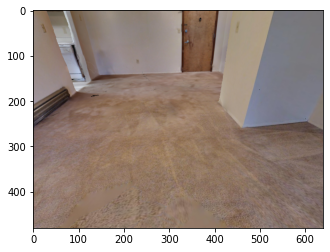

In [198]:
plt.imshow(obs['rgb'])

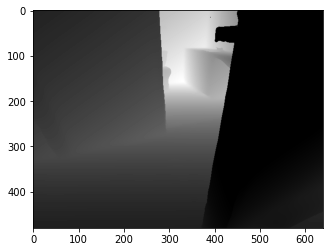

In [260]:
metrics = env.get_metrics()

plt.imshow(obs['depth'].reshape((480, 640)), cmap="gray")
plt.show()

In [259]:
for i in range(2):
    obs = env.step(1)

In [230]:
for i in range(4):
    obs = env.step(2)

In [27]:
for i in range(4):
    obs = env.step(3)

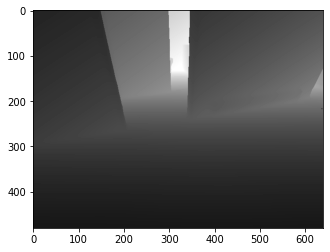

In [232]:
metrics = env.get_metrics()

plt.imshow(obs['depth'].reshape((480, 640)), cmap="gray")
plt.show()

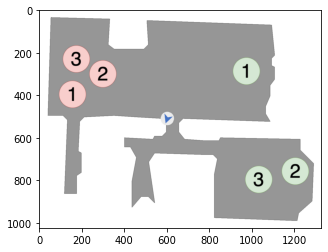

In [261]:
top_down_map, fog_of_war_mask = get_top_down_map(
    env, fog_of_war_mask, should_draw_fow=True, 
    should_draw_agent=True, should_draw_object=True
)

plt.imshow(top_down_map)
plt.show()

In [262]:
import torch 

from rearrangement.generate_maps.simulator import TourSim
from rearrangement.generate_maps.projection import (
    _transform3D, PointCloud
)
from rearrangement.generate_maps.projection.core import Projector
from rearrangement.generate_maps.utils import label_colours
from scipy.spatial.transform import Rotation as R

from torch_scatter import scatter_add


In [263]:
house_dim_min, house_dim_max = env._sim.pathfinder.get_bounds()

center = (house_dim_max + house_dim_min) / 2
sizes = house_dim_max - house_dim_min
sizes +=2 # pad scene bboxes

world_dim = sizes.copy(); world_dim[1] = 0.
central_pos = center.copy(); central_pos[1] = 0.

map_world_shift = central_pos - (world_dim / 2)
top_down_map_dims = [
    int(np.round(world_dim[0] / 0.02)),
    0,
    int(np.round(world_dim[2] / 0.02)),
]



In [264]:
top_down_map_dims, map_world_shift

([570, 0, 463], array([-7.237813 ,  0.       , -3.0645876], dtype=float32))

In [265]:
map_world_shift = torch.Tensor(map_world_shift).cuda()

In [266]:
# 4. init a point cloud projector for the tour
world_shift_origin = torch.zeros(3, device="cuda")
observed_occupancy_map = torch.zeros(
            size=(top_down_map_dims[2], top_down_map_dims[0]),
            dtype=torch.bool
        )

projector = Projector(
    vfov=(67.5 * np.pi/180),
    batch_size=1,
    feature_map_height=480,
    feature_map_width=640,
    output_height=1,
    output_width=1,
    gridcellsize=1,
    world_shift_origin=world_shift_origin,
    z_clip_threshold=0.5,
    device=world_shift_origin.device,
)

In [267]:
# 5.2 get the **sensor** state (separate from agent state)
sensor_state = env._sim.get_agent(0).get_state().sensor_states['depth']
sensor_pos, sensor_ori = (
    sensor_state.position,
    sensor_state.rotation
)

# 5.3 compute the 4x4 transformation matrix (camera -> world)
sensor_ori = np.asarray(
    [sensor_ori.x, sensor_ori.y, sensor_ori.z, sensor_ori.w],
    dtype=np.float32
)

rotation = R.from_quat(sensor_ori)
elevation, heading, _  = rotation.as_rotvec()
xyzhe = np.asarray(
    [[
        sensor_pos[0],
        sensor_pos[1],
        sensor_pos[2],
        heading,
        elevation, 
    ]],
    dtype=np.float32
)

xyzhe = torch.FloatTensor(xyzhe).to(world_shift_origin.device)
T = _transform3D(xyzhe, device=world_shift_origin.device)

# 5.4 render ego-centric semantic+depth map at current state
depth = obs["depth"]
depth = depth[:, :, 0].astype(np.float32)

depth *= 10.0 
depth = torch.FloatTensor(depth).unsqueeze(0).unsqueeze(0).to(
    device=world_shift_origin.device
)

In [268]:
xyzhe, T

(tensor([[-1.9576,  1.0356,  1.5421,  2.7062, -0.1279]], device='cuda:0'),
 tensor([[[-0.9067, -0.0538,  0.4184, -1.9576],
          [ 0.0000,  0.9918,  0.1275,  1.0356],
          [-0.4218,  0.1156, -0.8993,  1.5421],
          [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0'))

In [269]:
env._sim._default_agent.scene_node.transformation

Matrix(-0.939693, 0, 0.342021, -1.9576,
       0, 1, 0, 0.155629,
       -0.342021, 0, -0.939693, 1.54211,
       0, 0, 0, 1)

In [241]:
T = torch.tensor(np.array(env._sim._default_agent.scene_node.transformation), device=world_shift_origin.device).reshape(-1, 4, 4)

In [270]:
depth.shape

torch.Size([1, 1, 480, 640])

In [271]:
# 5.5 project the depth map to get a point cloud
# mask: (B=1, 480, 640) identifying non-zero depth values in the ego-centric frame
pc, xyz_c = projector.pixel_to_world_mapping(depth[0], T, 2.0)

In [272]:
camera_z = T[:,2,3]
above_threshold_z_indices = pc[:, :, :, 1] > (0)
# mask1 = mask & ~above_threshold_z_indices

In [279]:
dproj = np.copy(pc[0].cpu())[:, :, 1]
dxyz = np.copy(pc[0].cpu())

dmask = np.zeros_like(dproj)

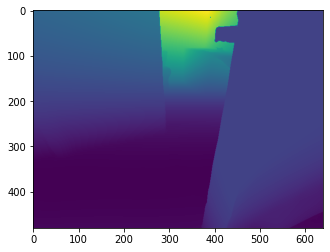

In [280]:
dmask[dproj >= 0.56] = 1
dmask[dproj >= 1.0] = 0
# dmask[depth[0, 0].cpu().numpy() == 0] = 0
plt.imshow(dxyz[:, :, 1])

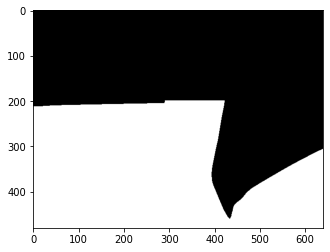

In [284]:
plt.imshow(dmask, cmap="gray")

(array([[207.,  84., 133., ...,   0.,   0.,   0.],
        [208.,  83., 133., ...,   0.,   0.,   0.],
        [208.,  83., 132., ...,   0.,   0.,   0.],
        ...,
        [ 98., 382.,   0., ...,   0.,   0.,   0.],
        [ 98., 382.,   0., ...,   0.,   0.,   0.],
        [ 99., 381.,   0., ...,   0.,   0.,   0.]]),
 array([0.64912176, 0.8466975 , 1.0442733 , 1.241849  , 1.4394248 ,
        1.6370004 , 1.8345761 , 2.032152  , 2.2297277 , 2.4273033 ,
        2.6248791 ], dtype=float32),
 <a list of 640 Lists of Patches objects>)

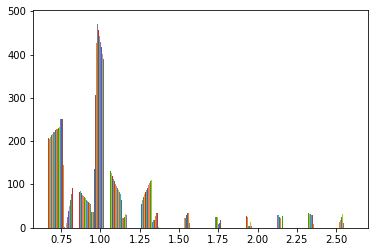

In [283]:
plt.hist(dproj)

In [285]:
xyz_c = torch.transpose(xyz_c, 1, 2).squeeze(0).reshape(480,640, -1)

In [286]:
xyz_c.shape

torch.Size([480, 640, 4])

In [291]:
print(xyz_c[350, 250], xyz_c[410, 380], xyz_c[0, 400], xyz_c[300, 300], xyz_c[450, 600])
print(dxyz[350, 480], dxyz[420, 380], dxyz[0, 400], dxyz[450, 600])

for i in range(len(env.current_episode.goals)):
    # print(env._task.objid_to_sim_object_mapping)
    objid = env._task.objid_to_sim_object_mapping[i]
    print(objid)
    print(env._sim.get_translation(objid))
    # env._sim.get_translation(1), env._sim.get_translation(2), env._sim.get_translation(3), env._sim.get_translation(4), env._sim.get_translation(5)

print(env._sim.get_agent(0).get_state().sensor_states['depth'].position)
print(env._sim.get_agent(0).get_state().position)

tensor([-0.2704, -0.2704, -0.2705, -0.2705], device='cuda:0') tensor([-0.6364, -0.6364, -0.6364, -0.6365], device='cuda:0') tensor([-2.7885, -2.7913, -2.7942, -2.7971], device='cuda:0') tensor([-0., -0., -0., -0.], device='cuda:0') tensor([1., 1., 1., 1.], device='cuda:0')
[-1.9575982  1.0356286  1.5421066] [-2.2962563   0.65895057  2.0003312 ] [-3.8555422  2.5205612  3.9628594] [-2.373367    0.78623474  1.7045964 ]
1
Vector(0.686641, 0.177339, -0.0276806)
2
Vector(2.31692, 0.247348, 3.30005)
3
Vector(1.10037, 0.168552, 3.57736)
[-1.9575982  1.0356286  1.5421066]
[-1.9575982  0.1556285  1.5421066]


In [288]:
tdmap = np.copy(top_down_map)

In [289]:
for i in range(dxyz.shape[0]):
    for j in range(dxyz.shape[1]):
        if dmask[i,j] == 1:
            val = dxyz[i, j]
            # val = val - map_world_shift.cpu().numpy()
            pos = maps.to_grid(val[2], val[0], top_down_map.shape[0:2] ,env._sim, env._sim.pathfinder)
            # pos = (pos[0]*2, pos[1]*2)
            if pos[0] < tdmap.shape[0] and pos[1] < tdmap.shape[1]:
                tdmap[pos[0], pos[1], :] = [0, 0, 0]


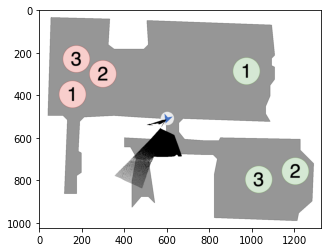

In [290]:
plt.imshow(tdmap)

In [89]:
camera_z = T[:,2,3]
print(camera_z)

tensor([1.0533], device='cuda:0')


In [90]:
# 5.6 map point-cloud to discrete top-down grid coordinates
tmp_pc = pc.clone() # (B=1, 480, 640, 3)
tmp_mask = np.copy(dmask)

tmp_pc = tmp_pc.view(-1, 3) # (1x480x640, 3)
tmp_mask = tmp_mask.reshape(-1)
tmp_pc -= map_world_shift # origin of world at upper-left of top-down map

# (x,z) grid-coordinates of points when projected to ground-plane
vertex_to_map_x = (tmp_pc[:, 0] / 0.02).round() # (1x480x640, float32)
vertex_to_map_z = (tmp_pc[:, 2] / 0.02).round() # (1x480x640, float32)

In [91]:
outside_map_indices = \
    (vertex_to_map_x >= top_down_map_dims[0]) +\
        (vertex_to_map_z >= top_down_map_dims[2]) +\
            (vertex_to_map_x < 0) +\
                (vertex_to_map_z < 0) # (1x480x640,)

In [92]:
outside_map_indices = torch.mul(torch.tensor(tmp_mask).type(torch.bool).to(world_shift_origin.device), outside_map_indices)

In [93]:
outside_map_indices

tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')

In [94]:
# 5.8 linearized (row-major) grid coordinates of projected points
feat_index = (
    top_down_map_dims[0] * vertex_to_map_z +\
         vertex_to_map_x
).long() # (1x480x640, int64)
feat_index = feat_index[~outside_map_indices]

print(feat_index.shape)

torch.Size([227052])


In [95]:
# 5.9 construct the observed top-down map for current state
# (by filling-in 1s at locations given by the grid-coordinates)
flat_curr_observed_map = torch.zeros(
    int(top_down_map_dims[0] * top_down_map_dims[2])
).to(device=world_shift_origin.device)

flat_curr_observed_map = scatter_add(
    torch.ones(feat_index.shape).to(world_shift_origin.device),
    feat_index,
    dim=0,
    out=flat_curr_observed_map,
) # (top_down_map_dims[2] x top_down_map_dims[0], float32)

In [96]:
flat_curr_observed_map

tensor([0., 0., 0.,  ..., 1., 0., 0.], device='cuda:0')

In [97]:
curr_observed_map = flat_curr_observed_map.reshape(
    top_down_map_dims[2], top_down_map_dims[0]
).to('cpu') # float32

# 5.10 update the tour's occupancy map with current map
curr_observed_map = curr_observed_map > 0
observed_occupancy_map += curr_observed_map # bool

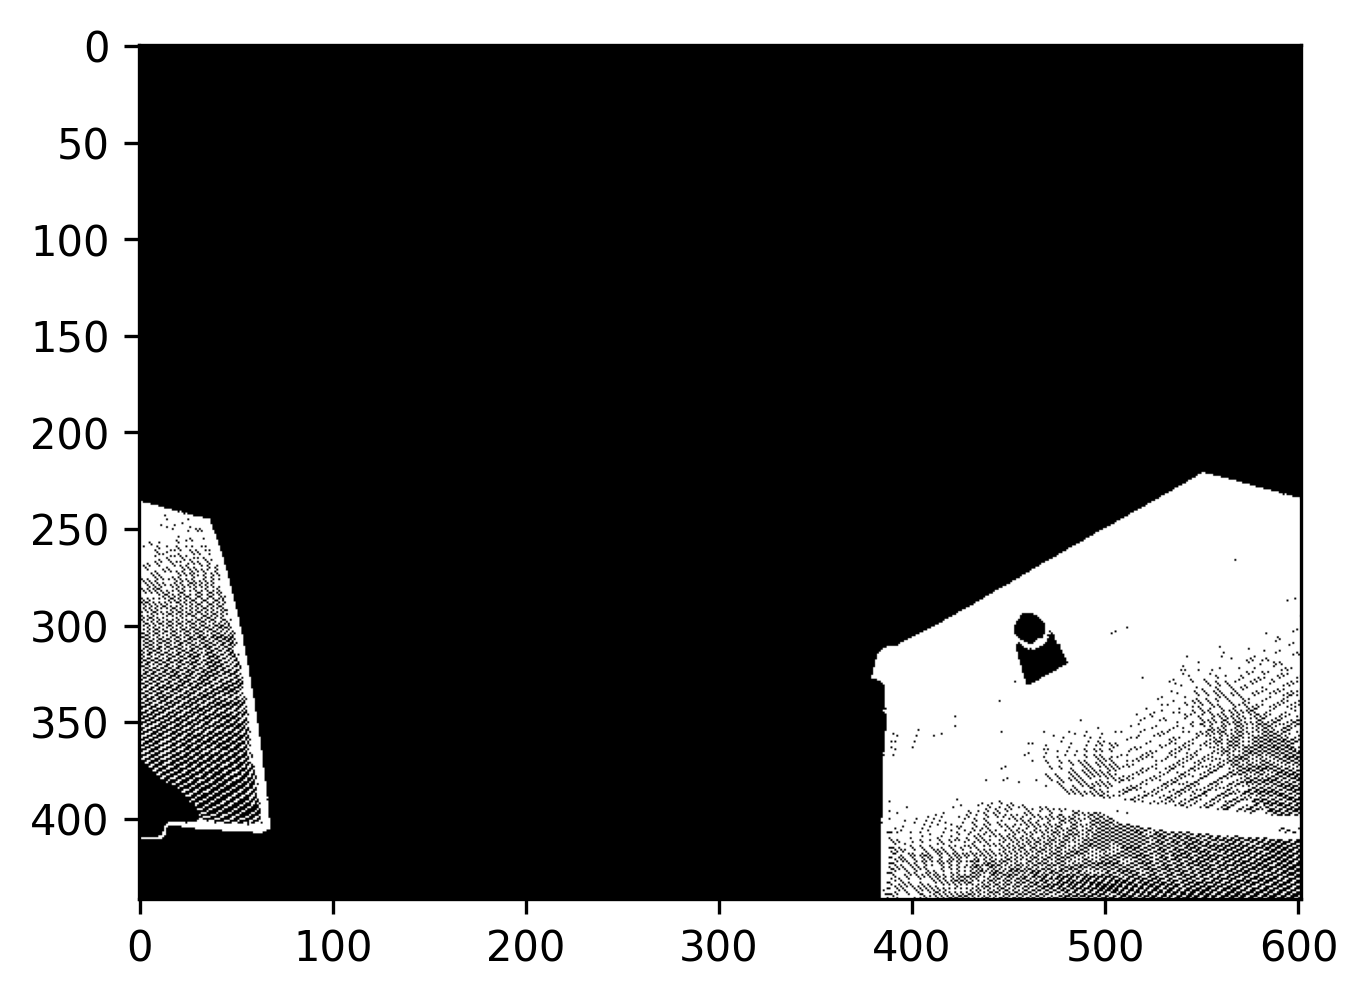

In [98]:
plt.figure(figsize=(5,5), dpi=300)
plt.imshow(curr_observed_map, cmap="gray")
plt.show()

In [99]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


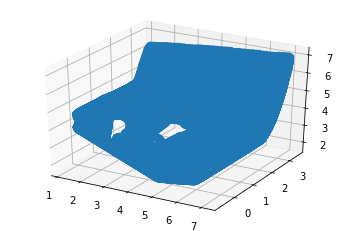

In [100]:
 fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = dxyz[:, :, 0].reshape(-1, 1)
y = dxyz[:, :, 1].reshape(-1, 1)
z = dxyz[:, :, 2].reshape(-1, 1)
ax.scatter(x, y, z)
plt.show()